In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import barplot

In [2]:
## to drop

notas = np.array(['NU_NOTA_CN','NU_NOTA_CH',
                  'NU_NOTA_LC','NU_NOTA_MT',
                  'NU_NOTA_REDACAO'])

drop_dados = [
    'NU_INSCRICAO', 'NO_MUNICIPIO_RESIDENCIA', 'SG_UF_RESIDENCIA',
    'CO_MUNICIPIO_NASCIMENTO','NO_MUNICIPIO_NASCIMENTO','CO_UF_NASCIMENTO',
    'SG_UF_NASCIMENTO']

drop_escola = [
    'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC']

drop_prova = [
    'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'SG_UF_PROVA']

drop_deficiencia = [
    'IN_BAIXA_VISAO','IN_CEGUEIRA','IN_SURDEZ','IN_DEFICIENCIA_AUDITIVA',
    'IN_SURDO_CEGUEIRA','IN_DEFICIENCIA_FISICA','IN_DEFICIENCIA_MENTAL',
    'IN_DEFICIT_ATENCAO','IN_DISLEXIA','IN_DISCALCULIA','IN_AUTISMO',
    'IN_VISAO_MONOCULAR','IN_OUTRA_DEF']

drop_especifico = [
    'IN_GESTANTE','IN_LACTANTE','IN_IDOSO','IN_ESTUDA_CLASSE_HOSPITALAR']

drop_especializado = [
    'IN_SEM_RECURSO','IN_ACESSO','IN_BRAILLE','IN_AMPLIADA_24','IN_AMPLIADA_18','IN_LEDOR',
    'IN_ACESSO','IN_TRANSCRICAO','IN_LIBRAS','IN_TEMPO_ADICIONAL',
    'IN_LEITURA_LABIAL','IN_MESA_CADEIRA_RODAS','IN_MESA_CADEIRA_SEPARADA',
    'IN_APOIO_PERNA','IN_GUIA_INTERPRETE','IN_COMPUTADOR','IN_CADEIRA_ESPECIAL',
    'IN_CADEIRA_CANHOTO','IN_CADEIRA_ACOLCHOADA','IN_PROVA_DEITADO','IN_MOBILIARIO_OBESO',
    'IN_LAMINA_OVERLAY','IN_PROTETOR_AURICULAR','IN_MEDIDOR_GLICOSE','IN_MAQUINA_BRAILE',
    'IN_SOROBAN','IN_MARCA_PASSO','IN_SONDA','IN_MEDICAMENTOS','IN_SALA_INDIVIDUAL',
    'IN_SALA_ESPECIAL','IN_SALA_ACOMPANHANTE','IN_MOBILIARIO_ESPECIFICO',
    'IN_MATERIAL_ESPECIFICO','IN_NOME_SOCIAL']



In [3]:
## --- feat eng

## -- features socioeconomicos
def eng_dsoec( chunk ):

    chunk['Q001'] = chunk['Q001'].apply(lambda x: 1 if (x=='F') or (x=='G') 
                                              else 0).astype('int8')

    chunk['Q002'] = chunk['Q002'].apply(lambda x: 1 if (x=='F') or (x=='G') 
                                              else 0).astype('int8')

    chunk['Q01_2'] = chunk['Q001'] + chunk['Q002']
    chunk.drop(['Q001','Q002'], axis=1, inplace=True)

    chunk['Q003'] = chunk['Q003'].apply(lambda x: 1 if (x=='D') or (x=='E') 
                                              else 0).astype('int8')

    chunk['Q004'] = chunk['Q004'].apply(lambda x: 1 if (x=='D') or (x=='E') 
                                              else 0).astype('int8')

    chunk['Q03_4'] = chunk['Q003'] + chunk['Q004']
    chunk.drop(['Q003','Q004'], axis=1, inplace=True)

    chunk['Q005'] = chunk['Q005'].apply(lambda x: 0 if (x<=4) else
                                            1 if (x>4) and (x<=8) else 
                                            2 if (x>8) and (x<20) else 3).astype('int8')

    chunk['Q006'] = chunk['Q006'].apply(lambda x: 0 if (x<='C') else
                                            1 if (x>'C') and (x<='F') else
                                            2 if (x>'F') and (x<='I') else 3).astype('int8')
    
    return chunk

## --- feat disab
def eng_scores(chunk):
    score_deficiencia = chunk[drop_deficiencia].sum(axis=1).astype('int8')
    score_especifico = chunk[drop_especifico].sum(axis=1).astype('int8')
    score_especializado = chunk[drop_especializado[1:]].sum(axis=1).astype('int8')
    
    return (score_deficiencia,
            score_especifico,
            score_especializado)

In [4]:
#df = pd.read_csv('train.csv',nrows=1)

reader = pd.read_csv('train.csv', chunksize=20000)

is_na = 0
lines = 0
with open('train_1st_eng.csv', 'w') as outFile:

    for chunk in reader:

        chunk.dropna(axis=0, how='all', inplace=True)
        
        ## -- conversão de tipos
        chunk['NU_IDADE'] = chunk['NU_IDADE'].fillna(chunk['NU_IDADE'].mean()).astype('int8')
        chunk['TP_STATUS_REDACAO'] = chunk['TP_STATUS_REDACAO'].fillna(0).astype('int8')

        ## -- feature engineering
        chunk['SCOR_DEFICIENCIA'], chunk['SCOR_ESPECIFICO'], chunk['SCOR_ESPECIALIZADO'] = eng_scores( chunk )
        chunk['NU_MED_NOTAS'] = chunk[notas].mean(axis=1)
        chunk = eng_dsoec(chunk)

        ## -- eliminação de dados pouco relevantes
        chunk.drop(np.concatenate((drop_deficiencia,
                        drop_especifico,
                        drop_especializado,
                        drop_dados,
                        drop_prova), axis=None), axis=1, inplace=True)
        chunk.drop(['TP_LINGUA'], axis=1, inplace=True)

        is_na = is_na + chunk.isna().sum(axis=0)
        lines = lines + len(chunk)

        ## -- removendo dados dos ausentes e eliminados
        chunk = chunk[(chunk['TP_PRESENCA_CN']+chunk['TP_PRESENCA_CH']+
                 chunk['TP_PRESENCA_LC']+chunk['TP_PRESENCA_MT']) ==4 ].copy()

        ## -- removendo redações anuladas (2,3,4,6,7,8,9)
        chunk = chunk[chunk['TP_STATUS_REDACAO']==1].copy()
        
        chunk.to_csv(outFile, header=None, index=False)
    

In [5]:
## -- identificando colunas com < 40% de missing values
to_read = is_na/lines < 0.4
to_read = {A:to_read.index.get_loc(A) for A in to_read.index if to_read[A] == True }

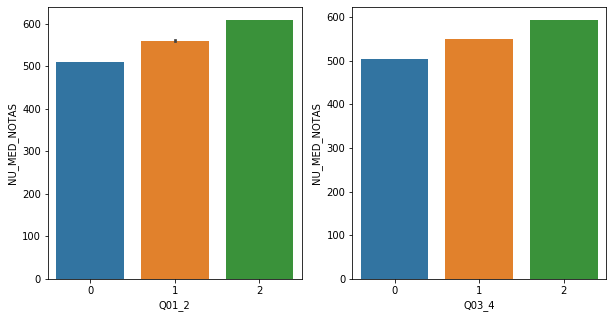

In [6]:
## --- EDA
fig, ax = plt.subplots(1,2, figsize=(10,5))

for axes, qn in zip(ax.reshape(-1), ['Q01_2','Q03_4']):
    data = pd.read_csv( 'train_1st_eng.csv', header=None, 
                       usecols=[to_read['NU_MED_NOTAS'],to_read[qn]] )
    barplot(x=to_read[qn], y=to_read['NU_MED_NOTAS'],
            data=data, 
            order=data[to_read[qn]].sort_values().unique(),
            ax= axes)
    axes.set_ylabel('NU_MED_NOTAS')
    axes.set_xlabel(qn)

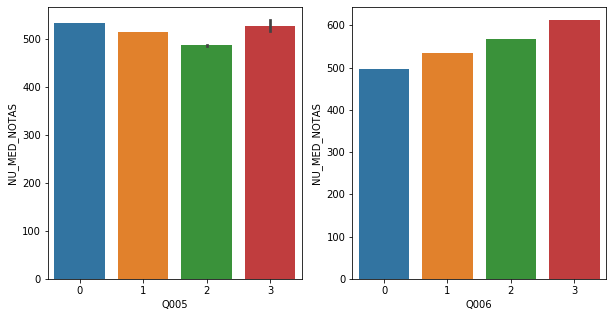

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

for axes, qn in zip(ax.reshape(-1), ['Q005','Q006']):
    data = pd.read_csv( 'train_1st_eng.csv', header=None, 
                       usecols=[to_read['NU_MED_NOTAS'],to_read[qn]] )
    barplot(x=to_read[qn], y=to_read['NU_MED_NOTAS'],
            data=data, 
            order=data[to_read[qn]].sort_values().unique(),
            ax= axes)
    axes.set_ylabel('NU_MED_NOTAS')
    axes.set_xlabel(qn)